Notebook for testing a 128 x 128 pixel clasification model on a gridded image.
Gridded image is created by splitting the image into squares of a specified size. The individual crops are then preprocessed by resizing them to 128x128 and then normalizing them. These are then passsed therough the classifier and their results used to label the original image. Healthy images are bordered by green and the unhealthy images are bordered by red.



In [ ]:
!git clone https://github.com/Virtana/Agri_Classification.git

Cloning into 'Agri_Classification'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 5), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (24/24), done.


In [ ]:
#import dependencies and create neural net architecture.
import torch.nn as nn
import torch.nn.functional as F
import os
import torch
from PIL import Image
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from PIL import Image
from tensorflow import io
from tensorflow import image
from matplotlib import pyplot as plt



class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 2)
        self.fc1 = nn.Linear(15376, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        #print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #print(x.shape)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [ ]:
PATH = '/content/Agri_Classification/Models/base_color_transform_nocorn_128p_.pth'

In [ ]:
#load in saved weights for the model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
#Create transform operation
test_transform = transforms.Compose([transforms.Resize((128)),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))]) 

In [ ]:
import numpy as np
#code to display a torch image
def imshow(img, correct = True):
    if(correct):
      img = img / 2 + 0.5     # unnormalize
    plt.rcParams["figure.figsize"] = (20,20)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
image = transforms.ToTensor()(Image.open('/content/Agri_Classification/Data/20220717_145704.jpg'))

In [ ]:
#function to grid images
def grid_image(image, transform, size = 128):
  imgs = []
  for i in range(image.shape[1] // size):
    #print(i)
    for j in range(image.shape[2] // size):
      imgs.append(transform(image[:,i*size:(i+1)*size, j*size:(j+1)*size]))
      #imgs.append(img[i*size:(i+1)*size, j*size:(j+1)*size, :])
  return imgs

In [ ]:
imgs = grid_image(image, test_transform, size = 512)

In [ ]:
#run images through the model
correct = 0
total = 0
predictions = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for img in imgs:
        inputs = torch.stack([img])
        # labels = labels.to(device)
        # calculate outputs by running images through the network
        outputs = net(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predictions.append(predicted)
        #total += labels.size(0)
        #correct += (predicted == labels).sum().item()
preds = torch.stack(predictions)

In [ ]:
def draw_box(image, tl, size, thickness = 60, color = 1):
  #print(color)
  #print(tl)
  t = thickness
  #image[color,tl[0]:tl[0]+ size,tl[1]:tl[1]+size] = 1
  image[color,tl[0]:tl[0]+ size,tl[1]: tl[1] + t] = 1 #left vertical
  image[color,tl[0]: tl[0] + t,tl[1]:tl[1]+ size] = 1 #top horizontal
  image[color,tl[0]:tl[0]+ size,tl[1] + size: tl[1] + size - t] = 1 #right vertical
  image[color,tl[0] + size: tl[0] + size - t,tl[1]:tl[1]+ size] = 1 #bottom horizontal
  return image

def label_grid(image, size, labels, draw_box):
  x = 0
  for i in range(image.shape[1] // size):
    for j in range(image.shape[2] // size):
      image = draw_box(image, (i*size,j*size), size, color = labels[x])
      x += 1
  return image

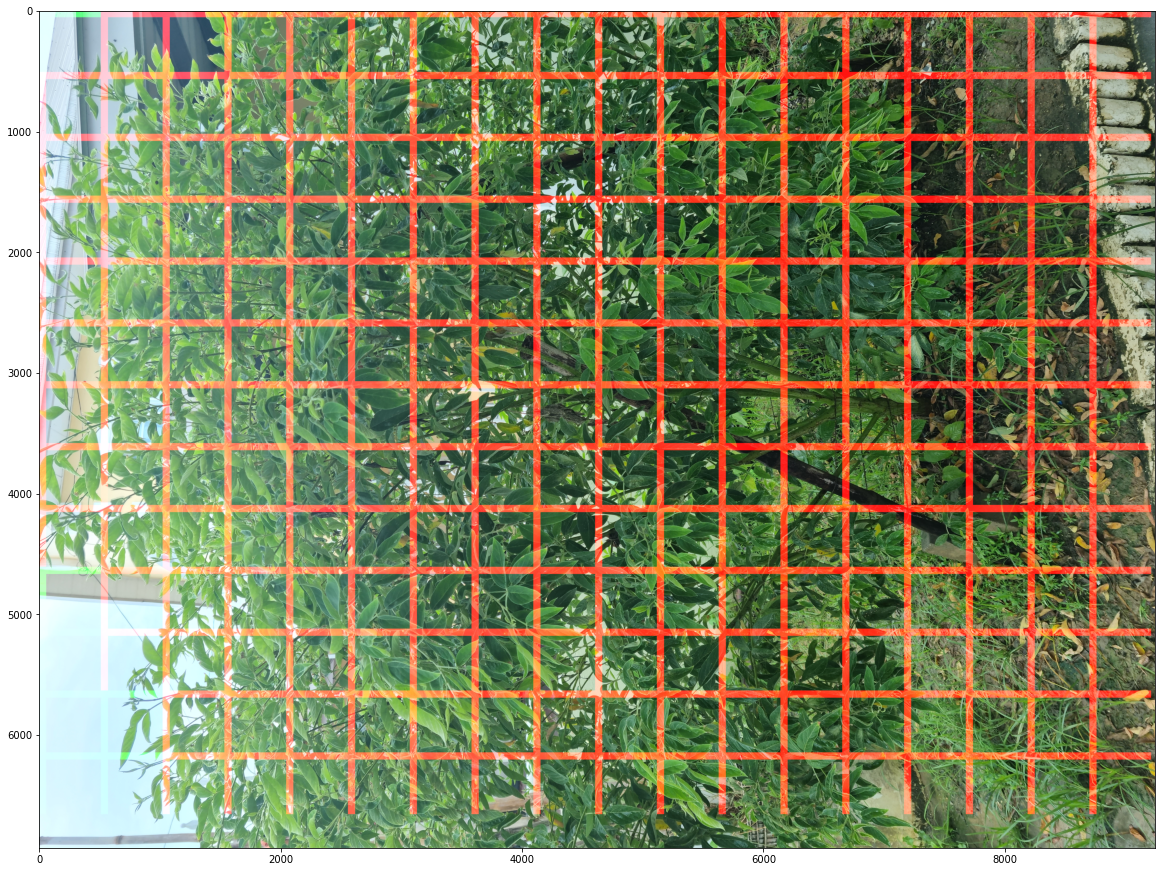

In [ ]:
copy_image = image.clone()
imshow(label_grid(copy_image, 512, preds, draw_box), False)